# Data Visualization and size investigation

So far we have power readings data in table where rows mean timestamp and columns mean components. We will use this data table to generate average power readings under each zip code. Before that, let's do some visualization and see the effect of component's size. 

In [41]:
#specify data source 
datasource = 'L'

In [42]:
#specify data zipcode (along with latitude, longitue, and timezone).
[zipcode, latitude, longitude, localtz] = ['08641', 40.0449, -74.5892, 'US/Eastern']
#[zipcode, latitude, longitude, localtz] = ['92562', 33.5686, -117.2530, 'US/Pacific']

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pytz
import os
import patsy #for spline regression
import scipy #for non-negative least square 
import scipy as sp 
from scipy import stats
from scipy.optimize import nnls
from numpy.linalg import inv #for matrix and statistics
import scipy as sp
import math
import statsmodels.api as sm
%matplotlib inline

In [44]:
#mainDir = 'C:/Users/Tee/Dropbox/Active/EnergyProject/Thesis/PVreadingsStudies/main'
mainDir = 'C:\Users\Admin\Dropbox\Active\EnergyProject\Thesis'
#read data and metadata
metadata = pd.read_csv(mainDir+ '/data/solar/' + datasource +'/' + zipcode +'/metadata.csv',
                             dtype={'componentId':'object','zip':'object'})
data = pd.read_csv(mainDir+ '/data/solar/' + datasource +'/'+ zipcode+'/data.csv',
                             dtype={'componentId':'object'})
#convert timestamp string to datetime format if needed
#metadata['FirstTimestamp'] = metadata['FirstTimestamp'].map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
#data['tsLocal'] = data['tsLocal'].map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))

## Component's size investigation

Let's look at summary of number of components in a zip code broken down by first time stamp and size of components. Since we are interested in distributed PV generation, we set a bin cutoff at 20 kW. Note that component's size is binned by our data provider due to confidentiality.

In [45]:
FirstTimestampBinList = ['pre-2013','2013-1','2013-2','2013-3','2013-4','2014-1','2014-2','2014-3','2014-4']
SizeBinList = ['0-1 kW','1-2 kW','2-3 kW','3-5 kW', '5-10 kW', '10-20 kW', '20-50 kW', '50-100 kW', '<20 kW', '>20 kW','unknown','sum']
NumberOfComponents = pd.DataFrame(0, index = FirstTimestampBinList, columns = SizeBinList)

#define quick function to add data
def add_data(NumberOfComponents, d, i):
    NumberOfComponents['0-1 kW'].iloc[i] = d[d.sizeBucket=='0-1 kW'].shape[0]
    NumberOfComponents['1-2 kW'].iloc[i] = d[d.sizeBucket=='1-2 kW'].shape[0]
    NumberOfComponents['2-3 kW'].iloc[i] = d[d.sizeBucket=='2-3 kW'].shape[0]
    NumberOfComponents['3-5 kW'].iloc[i] = d[d.sizeBucket=='3-5 kW'].shape[0]
    NumberOfComponents['5-10 kW'].iloc[i] = d[d.sizeBucket=='5-10 kW'].shape[0]
    NumberOfComponents['10-20 kW'].iloc[i] = d[d.sizeBucket=='10-20 kW'].shape[0]
    NumberOfComponents['20-50 kW'].iloc[i] = d[d.sizeBucket=='20-50 kW'].shape[0]
    NumberOfComponents['50-100 kW'].iloc[i] = d[d.sizeBucket=='50-100 kW'].shape[0]
    NumberOfComponents['<20 kW'].iloc[i] = d[d.sizeBucket=='0-1 kW'].shape[0] + d[d.sizeBucket=='1-2 kW'].shape[0] +\
                                          d[d.sizeBucket=='2-3 kW'].shape[0] + d[d.sizeBucket=='3-5 kW'].shape[0] +\
                                            d[d.sizeBucket=='5-10 kW'].shape[0] + d[d.sizeBucket=='10-20 kW'].shape[0]
    NumberOfComponents['>20 kW'].iloc[i] = d[d.sizeBucket=='20-50 kW'].shape[0] + d[d.sizeBucket=='50-100 kW'].shape[0]
    NumberOfComponents['unknown'].iloc[i] = d[pd.isnull(d.sizeBucket)].shape[0]
    NumberOfComponents['sum'].iloc[i] = d.shape[0]
    return NumberOfComponents;

d = metadata[metadata.FirstTimestamp.map(lambda x: (x <= '2013-01-01 00:00:00'))]
NumberOfComponents = add_data(NumberOfComponents, d, 0)
d = metadata[metadata.FirstTimestamp.map(lambda x: (x > '2013-01-01 00:00:00')&(x <= '2013-04-01 00:00:00'))]
NumberOfComponents = add_data(NumberOfComponents, d, 1)
d = metadata[metadata.FirstTimestamp.map(lambda x: (x > '2013-04-01 00:00:00')&(x <= '2013-07-01 00:00:00'))]
NumberOfComponents = add_data(NumberOfComponents, d, 2)
d = metadata[metadata.FirstTimestamp.map(lambda x: (x > '2013-07-01 00:00:00')&(x <= '2013-10-01 00:00:00'))]
NumberOfComponents = add_data(NumberOfComponents, d, 3)
d = metadata[metadata.FirstTimestamp.map(lambda x: (x > '2013-10-01 00:00:00')&(x <= '2014-01-01 00:00:00'))]
NumberOfComponents = add_data(NumberOfComponents, d, 4)
d = metadata[metadata.FirstTimestamp.map(lambda x: (x > '2014-01-01 00:00:00')&(x <= '2014-04-01 00:00:00'))]
NumberOfComponents = add_data(NumberOfComponents, d, 5)
d = metadata[metadata.FirstTimestamp.map(lambda x: (x > '2014-04-01 00:00:00')&(x <= '2014-07-01 00:00:00'))]
NumberOfComponents = add_data(NumberOfComponents, d, 6)
d = metadata[metadata.FirstTimestamp.map(lambda x: (x > '2014-07-01 00:00:00')&(x <= '2014-10-01 00:00:00'))]
NumberOfComponents = add_data(NumberOfComponents, d, 7)
d = metadata[metadata.FirstTimestamp.map(lambda x: (x > '2014-10-01 00:00:00')&(x <= '2015-01-01 00:00:00'))]
NumberOfComponents = add_data(NumberOfComponents, d, 8)

NumberOfComponents

,0-1 kW,1-2 kW,2-3 kW,3-5 kW,5-10 kW,10-20 kW,20-50 kW,50-100 kW,<20 kW,>20 kW,unknown,sum
pre-2013,0,0,0,0,0,5,10,0,5,10,2,17
2013-1,0,0,0,0,4,36,61,0,40,61,37,138
2013-2,0,0,0,1,8,3,1,0,12,1,6,19
2013-3,0,0,0,1,64,16,1,0,81,1,76,158
2013-4,0,0,2,1,48,48,7,0,99,7,179,285
2014-1,0,0,0,0,0,4,14,4,4,18,97,119
2014-2,0,0,0,0,0,0,0,0,0,0,0,0
2014-3,0,0,0,0,0,0,0,0,0,0,0,0
2014-4,0,0,0,0,0,0,0,0,0,0,2,2


## Data visualization

For each component, one can look at power readings as a function of (time of day, date). This leads to 2-dimensional grid representation.

In [46]:
#Select a component in data table.
ComponentName = data.columns.values[4]
ComponentName

'1994469'

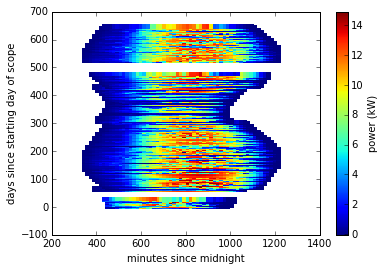

In [47]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import pylab
Ref = datetime.datetime.strptime(data.tsLocal.iloc[0],"%Y-%m-%d %H:%M:%S").date()
x = data.tsLocal.map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S").hour*60 \
                     + datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S").minute)
y = data.tsLocal.map(lambda x: (datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S").date()-Ref).days)
plt.scatter(x, y, c= data[ComponentName], edgecolors='none',marker=',',s=20)
plt.xlabel('minutes since midnight')
plt.ylabel('days since starting day of scope')
cbar = plt.colorbar()
cbar.ax.set_ylabel('power (kW)')

For each date, one can look at power readings as a function of time of day from differenet components at the same time. This leads to daily profile slice representation.

In [48]:
DateOfInterest = "2014-06-21"

C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


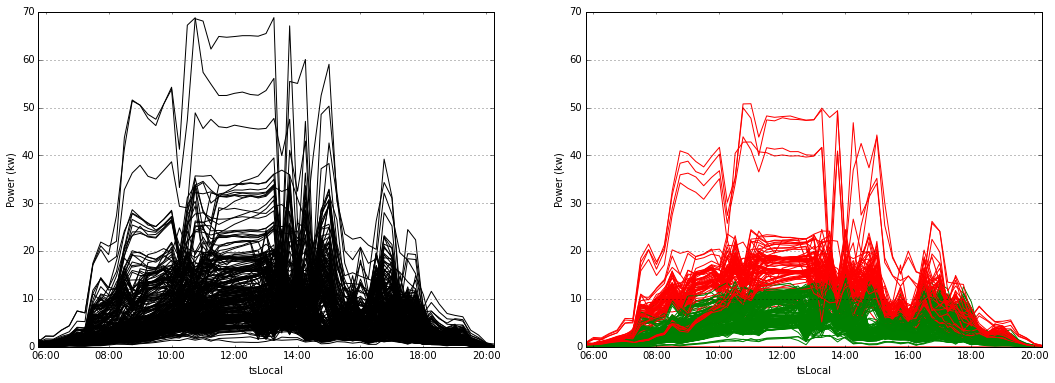

In [49]:
df = data[data.tsLocal.map(lambda x: x[0:10] == DateOfInterest)]
df.tsLocal = df.tsLocal.map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
df.drop(['altitude','azimuth'], axis=1, inplace=True)
df.set_index('tsLocal',inplace=True)

fig = plt.figure(figsize=(18,6))
ax1  = fig.add_subplot(121)
for i in df.columns.values:
    if metadata[metadata.componentId==i].sizeBucket.all() in ['0-1 kW','1-2 kW','2-3 kW','3-5 kW', '5-10 kW', '10-20 kW']:
        a=0#df[i].plot(legend=False,color ='green')
    elif metadata[metadata.componentId==i].sizeBucket.all() in ['20-50 kW', '50-100 kW']:
        a=0#df[i].plot(legend=False,color ='red')
    else:
        #df[i].plot(legend=False,color ='black',lw=0.1)
        df[i].plot(legend=False,color ='black')
        
ax1.set_ylim(0,70)
plt.ylabel('Power (kw)')

ax1  = fig.add_subplot(122)
for i in df.columns.values:
    if metadata[metadata.componentId==i].sizeBucket.all() in ['0-1 kW','1-2 kW','2-3 kW','3-5 kW', '5-10 kW', '10-20 kW']:
        df[i].plot(legend=False,color ='green')
    elif metadata[metadata.componentId==i].sizeBucket.all() in ['20-50 kW', '50-100 kW']:
        df[i].plot(legend=False,color ='red')
    else:
        a=0#df[i].plot(legend=False,color ='black',lw=0.1)
        
ax1.set_ylim(0,70)        
plt.ylabel('Power (kw)')

To comprehend the variation over days, one should summarize daily profiles into a number. There are two numbers one can extract easily from the profile: daily energy production $E$ and daily maximum power reading $m$. Here we assume that input data table has all active time stamps (sun is up) in that day (containing NaN if there is no power reading).

In [50]:
df = data[data.columns.values]
df['date'] = df.tsLocal.map(lambda x: x[0:10])
df.drop(['tsLocal','altitude','azimuth'], axis=1, inplace=True)
E = df.groupby(['date']).agg(lambda x: x.sum(skipna=False)/15*60)
m = df.groupby(['date']).agg(lambda x: x.max(skipna=False))
E.reset_index(inplace=True)
m.reset_index(inplace=True)
E.date = E.date.map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d"))
m.date = m.date.map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d"))
E.set_index('date',inplace=True)
m.set_index('date',inplace=True)

## Understanding size effect

Let's consider $E$ and $m$ for components with size less than 20 kW. Since most of components of consideration are in either 5-10 kW or 10-20 kW bin, we visualize data from these two bins separately. Red color represents components in 10-20 kW bin and green color represents components in 5-10 kW bin. To ease our eyes, instead of plot all data, we plot mean of $E$ and $m$ for each day with black line. We add standard deviation band (dark color) and range (light color) of $E$ and $m$ for each day as well. Note that the number of components in each bin grows as time increases in the calculation.  

(0.54069484911171928, 0.066774847905904711)

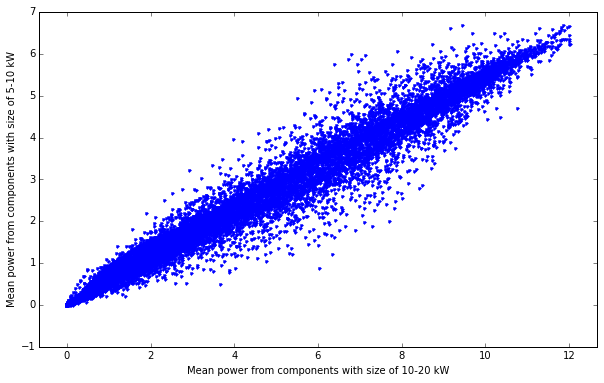

In [51]:
#additional investigation for average power
data['mean_1020bucket'] = data[list(metadata.componentId[metadata.sizeBucket == '10-20 kW'])].mean(axis=1)
data['mean_0510bucket'] = data[list(metadata.componentId[metadata.sizeBucket == '5-10 kW'])].mean(axis=1)
data['count_1020bucket'] = data[list(metadata.componentId[metadata.sizeBucket == '10-20 kW'])].count(axis=1)
data['count_0510bucket'] = data[list(metadata.componentId[metadata.sizeBucket == '5-10 kW'])].count(axis=1)
fig = plt.figure(figsize=(10,6))
ax1  = fig.add_subplot(111)
if zipcode == '92562':
    num = 10
if zipcode == '08641':
    num = 100
x = data['mean_0510bucket'][(data['count_1020bucket']>10)&(data['count_0510bucket']>num)]
y = data['mean_1020bucket'][(data['count_1020bucket']>10)&(data['count_0510bucket']>num)]
ax1.plot(y,x,'.')
ax1.axis('equal')
ax1.set_xlabel('Mean power from components with size of 10-20 kW')
ax1.set_ylabel('Mean power from components with size of 5-10 kW')
slope, intercept = np.polyfit(y, x, 1)
slope, intercept

C:\Users\Admin\Anaconda\lib\site-packages\matplotlib\figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


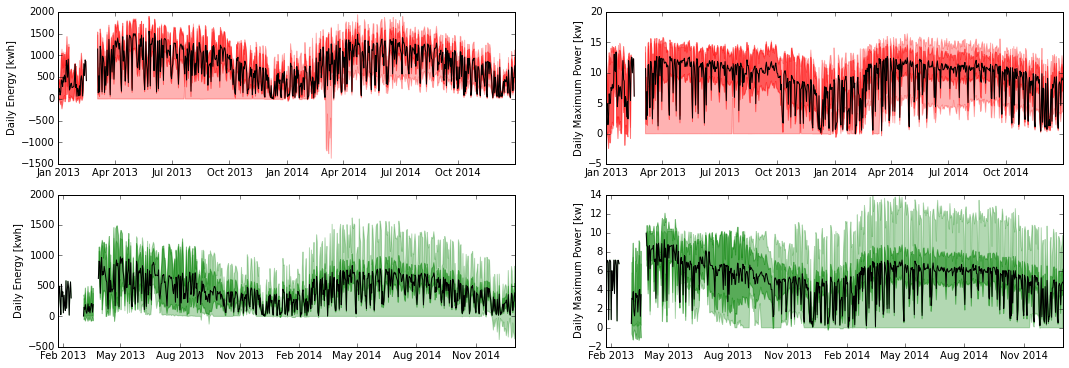

In [16]:
fig = plt.figure(figsize=(18,6))
ax1  = fig.add_subplot(221)
df1 = pd.DataFrame()
df1['mean'] = E[list(metadata.componentId[metadata.sizeBucket == '10-20 kW'])].mean(axis=1)
df1['max'] = E[list(metadata.componentId[metadata.sizeBucket == '10-20 kW'])].max(axis=1)
df1['min'] = E[list(metadata.componentId[metadata.sizeBucket == '10-20 kW'])].min(axis=1)
df1['std'] = E[list(metadata.componentId[metadata.sizeBucket == '10-20 kW'])].std(axis=1)

ax1.plot(df1.index,df1['mean'],color='black')
ax1.fill_between(df1.index, df1['min'], df1['max'], color='red', alpha='0.3')
ax1.fill_between(df1.index, df1['mean'] - df1['std'], df1['mean'] + df1['std'], color='red', alpha='0.5')        
ax1.set_ylabel('Daily Energy [kwh]')

ax2  = fig.add_subplot(222)
df2 = pd.DataFrame()
df2['mean'] = m[list(metadata.componentId[metadata.sizeBucket == '10-20 kW'])].mean(axis=1)
df2['max'] = m[list(metadata.componentId[metadata.sizeBucket == '10-20 kW'])].max(axis=1)
df2['min'] = m[list(metadata.componentId[metadata.sizeBucket == '10-20 kW'])].min(axis=1)
df2['std'] = m[list(metadata.componentId[metadata.sizeBucket == '10-20 kW'])].std(axis=1)

ax2.plot(df2.index,df2['mean'],color='black')
ax2.fill_between(df2.index, df2['min'], df2['max'], color='red', alpha='0.3')
ax2.fill_between(df2.index, df2['mean'] - df2['std'], df2['mean'] + df2['std'], color='red', alpha='0.5')            
ax2.set_ylabel('Daily Maximum Power [kw]')

ax3  = fig.add_subplot(223)
df3 = pd.DataFrame()
df3['mean'] = E[list(metadata.componentId[metadata.sizeBucket == '5-10 kW'])].mean(axis=1)
df3['max'] = E[list(metadata.componentId[metadata.sizeBucket == '5-10 kW'])].max(axis=1)
df3['min'] = E[list(metadata.componentId[metadata.sizeBucket == '5-10 kW'])].min(axis=1)
df3['std'] = E[list(metadata.componentId[metadata.sizeBucket == '5-10 kW'])].std(axis=1)

ax3.plot(df3.index,df3['mean'],color='black')
ax3.fill_between(df3.index, df3['min'], df3['max'], color='green', alpha='0.3')
ax3.fill_between(df3.index, df3['mean'] - df3['std'], df3['mean'] + df3['std'], color='green', alpha='0.5')        
ax3.set_ylabel('Daily Energy [kwh]')

ax4  = fig.add_subplot(224)
df4 = pd.DataFrame()
df4['mean'] = m[list(metadata.componentId[metadata.sizeBucket == '5-10 kW'])].mean(axis=1)
df4['max'] = m[list(metadata.componentId[metadata.sizeBucket == '5-10 kW'])].max(axis=1)
df4['min'] = m[list(metadata.componentId[metadata.sizeBucket == '5-10 kW'])].min(axis=1)
df4['std'] = m[list(metadata.componentId[metadata.sizeBucket == '5-10 kW'])].std(axis=1)

ax4.plot(df4.index,df4['mean'],color='black')
ax4.fill_between(df4.index, df4['min'], df4['max'], color='green', alpha='0.3')
ax4.fill_between(df4.index, df4['mean'] - df4['std'], df4['mean'] + df4['std'], color='green', alpha='0.5')            
ax4.set_ylabel('Daily Maximum Power [kw]')
'''
ax1.legend()
from collections import OrderedDict
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax1.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5),title='component size')
'''

fig.show()


Now, one might wonder if there is linear relationship between size and generated power of a component. We cannot answer that question since we do not know exact size of each component. However, we can test if there is linear relationship between average size and average generated power of components in a zipcode. Here we assume that the average size of components in 5-10 kW bin is 7.5 kW and the average size of components in 10-20 kW bin is 15 kW. If we plot any quantity representing average generated power (in this case $E$ and $m$ on black lines) from two bins, we expect to see a linear trend with ratio 15:7.5 = 2:1.

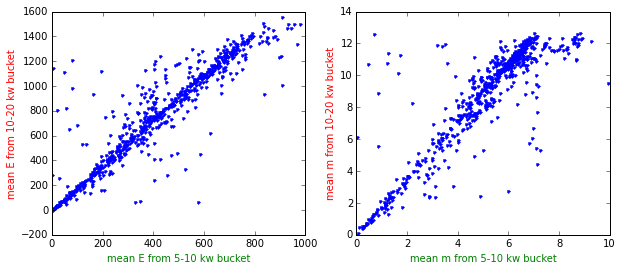

In [17]:
fig = plt.figure(figsize=(10,4))
ax1  = fig.add_subplot(121)
ax1.plot(df3['mean'],df1['mean'],'.')
ax1.set_xlabel('mean E from 5-10 kw bucket',color='green')
ax1.set_ylabel('mean E from 10-20 kw bucket',color='red')
ax1  = fig.add_subplot(122)
ax1.plot(df4['mean'],df2['mean'],'.')
ax1.set_xlabel('mean m from 5-10 kw bucket',color='green')
ax1.set_ylabel('mean m from 10-20 kw bucket',color='red')

For 08641, for plots above, one can see linear relation between two groups with ratio about 11:6. The deviation might come from the fact that actual means in buckets are different from 15 and 7.5. Anyway, this leads to a way to represent power readings in each zipcode: use average power readings in each zipcode by component's size. From this representation, we can scale this average power readings with total installation in each zipcode once we apply it to penetration problem in electricity.

Note: if we are assuming that the installation size of a component and its daily energy production is proportional. We may estimate the size of component by scaling. Suppose we know the size of a component. Then we can calculate energy production in a year (or any relatively long period of time) for each component and find its size by multiplying known size with the ratio of their energy productions.